# Simple Linear Autoencoder for MNIST

In [1]:
%matplotlib inline
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.activations as activations
from tensorflow.python.keras.models import Model
import os
import scipy
from tqdm import tqdm
import numpy as np
import util
from matplotlib import pyplot as plt

## Some Helper Functions

In [2]:
def show_image(img):
    plt.figure()
    plt.imshow(img)
    plt.show()

In [3]:
def show_side_by_side(img1, img2):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.show()

## The Dataset

Loading the MNIST Dataset. Ignoring the y values, since they are not needed to train the autoencoder. 

In [33]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

There are 60,000 images of numbers with values ranging from 0 to 255.

In [34]:
x_train.shape

(60000, 28, 28)

In [35]:
np.max(x_train)

255

In [36]:
np.min(x_train)

0

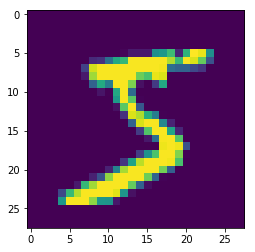

In [37]:
show_image(x_train[0])

Normalizing the dataset to values betweeen 0 and 1.

In [38]:
x_train = (x_train - 127.5) / 255
x_test = (x_test - 127.5) / 255

In [39]:
np.max(x_train)

0.5

In [40]:
np.min(x_train)

-0.5

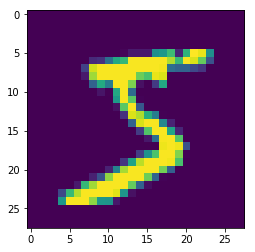

In [41]:
show_image(x_train[0])

## The Model

Defining some constants for later. Even if the memory permits it, do not use too large a BATCH_SIZE, that can decreas learning rate A LOT, probably connected to the effect obeserved here: https://arxiv.org/pdf/1609.04836.pdf.

In [13]:
LEARNING_RATE = 0.002
BATCH_SIZE = 100
EPOCHS = 30

Building the Model of the autoencoder. Just a simple linear model.

In [14]:
input_layer = layers.Input(shape=(28,28))

x = layers.Flatten()(input_layer) # 28*28=784
x = layers.Dense(256, activation=activations.relu)(x)
x = layers.Dense(2, activation=activations.relu, name="bottleneck")(x)
x = layers.Dense(256, activation=activations.relu)(x)
x = layers.Dense(784, activation=activations.tanh)(x)

output_layer = layers.Reshape((28,28))(x)

model = Model(input_layer, output_layer)

Defining the optimizer and loss function. Using the Adam optimizer and mean squared error loss.

In [15]:
optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
loss = keras.losses.mean_squared_error

Compiling the model.

In [16]:
model.compile(optimizer=optimizer, loss=loss)

Fitting the model to the data. The input and output data is the same, to teach the autoencoder to recover the original input.

In [17]:
history = model.fit(x=x_train, y=x_train, batch_size=BATCH_SIZE, validation_data=(x_test, x_test), epochs=EPOCHS, shuffle=True, verbose=2, )

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
 - 5s - loss: 0.0571 - val_loss: 0.0512
Epoch 2/30
 - 3s - loss: 0.0496 - val_loss: 0.0480
Epoch 3/30
 - 3s - loss: 0.0474 - val_loss: 0.0463
Epoch 4/30
 - 3s - loss: 0.0462 - val_loss: 0.0457
Epoch 5/30
 - 3s - loss: 0.0453 - val_loss: 0.0449
Epoch 6/30
 - 3s - loss: 0.0448 - val_loss: 0.0442
Epoch 7/30
 - 3s - loss: 0.0442 - val_loss: 0.0440
Epoch 8/30
 - 3s - loss: 0.0438 - val_loss: 0.0435
Epoch 9/30
 - 3s - loss: 0.0435 - val_loss: 0.0433
Epoch 10/30
 - 3s - loss: 0.0432 - val_loss: 0.0429
Epoch 11/30
 - 3s - loss: 0.0429 - val_loss: 0.0429
Epoch 12/30
 - 3s - loss: 0.0427 - val_loss: 0.0425
Epoch 13/30
 - 3s - loss: 0.0425 - val_loss: 0.0420
Epoch 14/30
 - 3s - loss: 0.0422 - val_loss: 0.0422
Epoch 15/30
 - 3s - loss: 0.0421 - val_loss: 0.0418
Epoch 16/30
 - 3s - loss: 0.0420 - val_loss: 0.0420
Epoch 17/30
 - 3s - loss: 0.0418 - val_loss: 0.0416
Epoch 18/30
 - 3s - loss: 0.0416 - val_loss: 0.0416
Epoch 19/30
 - 3s - los

## Visualizing the Results

In [18]:
history.history.keys()

dict_keys(['val_loss', 'loss'])

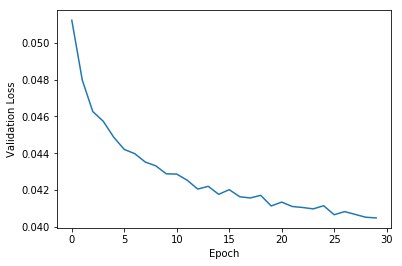

In [19]:
plt.figure()
plt.plot(history.history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.show()

Using the model on the complete test set.

In [20]:
results = model.predict(x_test)

Visualizing some examples. On the left is the original image, on the right is the image recovered by the autoencoder.

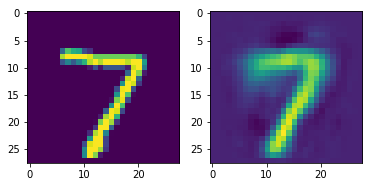

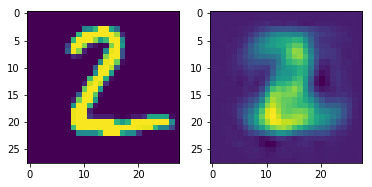

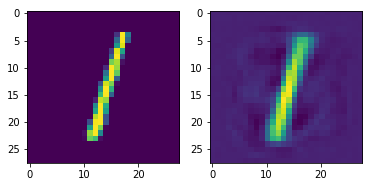

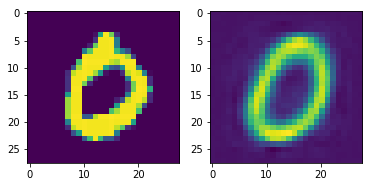

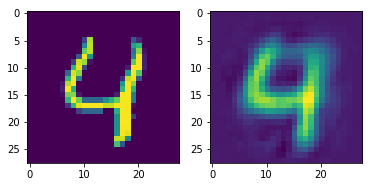

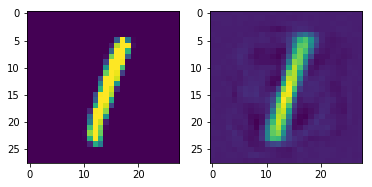

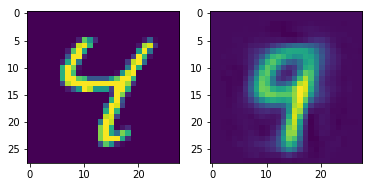

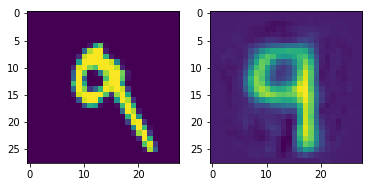

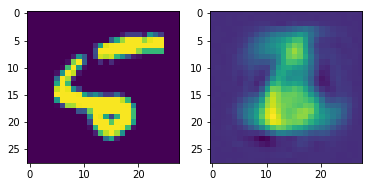

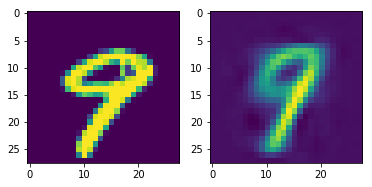

In [21]:
for i in range(10):
    show_side_by_side(x_test[i], results[i])

Just the encoder part of the autoencoder

In [23]:
encoder = Model(model.input, model.get_layer(name="bottleneck").output)

Calculating the encoded version of the test data

In [24]:
encoded_data = encoder.predict(x_test)

The resulting data is not in the right shape to be represented on a scatter plot, so it has to be transposed. This way all the x values are in one array and all the y values are in another.

In [25]:
encoded_data[0]

array([10.943481, 14.559638], dtype=float32)

In [26]:
encoded_data.shape

(10000, 2)

In [28]:
transposed_encoded_data = np.transpose(encoded_data)
transposed_encoded_data.shape

(2, 10000)

Randomly generating a color map of 10 colors, one color for each digit. Using that map and the labels, generating an array containing the color instad of the label, for each sample of the test data. 

In [43]:
color_map = [(np.random.uniform(0.0, 1.0),\
              np.random.uniform(0.0, 1.0),\
              np.random.uniform(0.0, 1.0),\
              1.0) for _ in range(10)]

colors = [color_map[y_test[i]] for i in range(len(y_test))]

Plotting each sample on a scatter plot. THe encoded data has 2 dimensions and can thus be represented on a 2D scatter Plot. Each digit has a different color assigned to it. This way we can see how the different digits clearly take on values in different areas of the 2D space.

I think that's pretty cool!

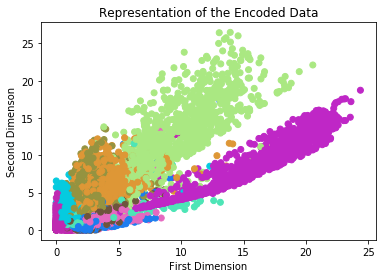

In [45]:
plt.figure()
plt.scatter(x=transposed_encoded_data[0], y=transposed_encoded_data[1], c=colors)
plt.xlabel("First Dimension")
plt.ylabel("Second Dimenson")
plt.title("Representation of the Encoded Data")
plt.show()

## Saving the model

In [22]:
model.save('mnist_autoencoder.h5')